In [1]:
from pdfminer.pdfinterp import PDFResourceManager, process_pdf
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from io import StringIO
from io import open
from urllib.request import urlopen
import re
import os

In [2]:
def read_pdf_file(pdfFile):
    pdfrm = PDFResourceManager()
    strio = StringIO()
    lapa = LAParams()
    device = TextConverter(pdfrm, strio, laparams = lapa)
    
    process_pdf(pdfrm, device, pdfFile)
    device.close()
    
    content = strio.getvalue()
    strio.close()
    return content

In [3]:
new_ESG_standard = open("standard/신ESG모범규준.pdf", "rb")
new_ESG_standard = read_pdf_file(new_ESG_standard)
new_ESG_standard.close() 

AttributeError: 'str' object has no attribute 'close'

In [44]:
from konlpy.tag import Mecab
mecab = Mecab()

tokens = []
def word_token (x) :
    for token in mecab.pos(x):
        tokens.append(token)
    return tokens

word_token(new_ESG_standard)

[('(', 'SSO'),
 ('cid', 'SL'),
 (':', 'SC'),
 ('47', 'SN'),
 (')', 'SSC'),
 ('(', 'SSO'),
 ('cid', 'SL'),
 (':', 'SC'),
 ('51', 'SN'),
 (')', 'SSC'),
 ('(', 'SSO'),
 ('cid', 'SL'),
 (':', 'SC'),
 ('54', 'SN'),
 (')', 'SSC'),
 ('(', 'SSO'),
 ('cid', 'SL'),
 (':', 'SC'),
 ('41', 'SN'),
 (')', 'SSC'),
 ('(', 'SSO'),
 ('cid', 'SL'),
 (':', 'SC'),
 ('37', 'SN'),
 (')', 'SSC'),
 ('(', 'SSO'),
 ('cid', 'SL'),
 (':', 'SC'),
 ('4', 'SN'),
 (')', 'SSC'),
 ('(', 'SSO'),
 ('cid', 'SL'),
 (':', 'SC'),
 ('39', 'SN'),
 (')', 'SSC'),
 ('(', 'SSO'),
 ('cid', 'SL'),
 (':', 'SC'),
 ('51', 'SN'),
 (')', 'SSC'),
 ('(', 'SSO'),
 ('cid', 'SL'),
 (':', 'SC'),
 ('54', 'SN'),
 (')', 'SSC'),
 ('(', 'SSO'),
 ('cid', 'SL'),
 (':', 'SC'),
 ('52', 'SN'),
 (')', 'SSC'),
 ('(', 'SSO'),
 ('cid', 'SL'),
 (':', 'SC'),
 ('51', 'SN'),
 (')', 'SSC'),
 ('(', 'SSO'),
 ('cid', 'SL'),
 (':', 'SC'),
 ('54', 'SN'),
 (')', 'SSC'),
 ('(', 'SSO'),
 ('cid', 'SL'),
 (':', 'SC'),
 ('37', 'SN'),
 (')', 'SSC'),
 ('(', 'SSO'),
 ('cid', 'S

In [45]:
from konlpy.tag import Mecab
mecab = Mecab()
stop = ["위해", "등", "및", "경우", "한다", "위한", "부록"]

nodes = [t[0] for t in tokens]
vocab = [t[0] for t in tokens if t[0] not in stop if t[1] in ['NNG', 'NNP'] and len(t[0]) > 1]

print(nodes[:10])
print(vocab[:10])


['(', 'cid', ':', '47', ')', '(', 'cid', ':', '51', ')']
['환경', '모범', '규준', '전문', '리더십', '거버넌스', '위험', '관리', '운영', '성과']


In [46]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

count = Counter(vocab)
words = dict(count.most_common())

%matplotlib inline 
import matplotlib 
from IPython.display import set_matplotlib_formats 
matplotlib.rc('font',family = 'Malgun Gothic') 
set_matplotlib_formats('retina') 
matplotlib.rc('axes',unicode_minus = False)

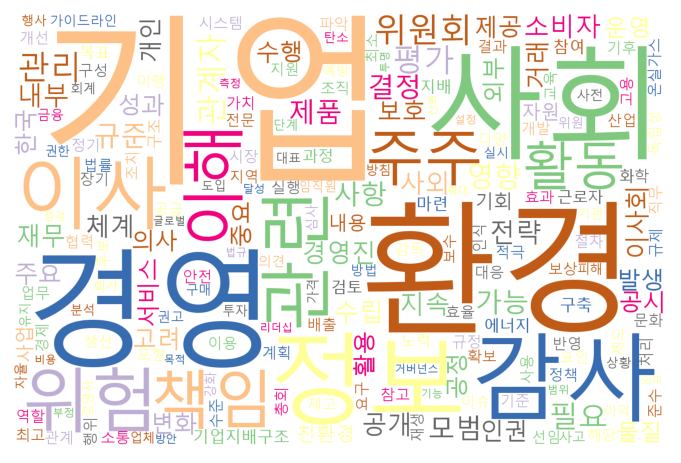

In [47]:
wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf', background_color='white',colormap = "Accent_r", 
                      width=1500, height=1000).generate_from_frequencies(words) 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.show()

In [48]:
vocab = list(set(vocab))

vocab2idx = {vocab[i]:i for i in range(len(vocab))}
idx2vocab = {i:vocab[i] for i in range(len(vocab))}

In [49]:
import numpy as np
import math

vocab_len = len(vocab2idx)

# 토큰별로 그래프 edge를 Matrix 형태로 생성
weighted_edge = np.zeros((vocab_len,vocab_len),dtype=np.float32)

# 각 토큰 노드별로 스코어 1로 초기화
score = np.ones((vocab_len),dtype=np.float32)

# coocurrence를 판단하기 위한 window 사이즈 설정
window_size = 4
covered_coocurrences = []

for window_start in range(len(nodes) - window_size + 1):
    window = nodes[window_start:window_start+window_size]
    for i in range(window_size):
        for j in range(i+1, window_size):
            if window[i] in vocab and window[j] in vocab:
                index_i = window_start + i
                index_j = window_start + j

                if (index_i, index_j) not in covered_coocurrences:
                    weighted_edge[vocab2idx[window[i]]][vocab2idx[window[j]]] = 1
                    weighted_edge[vocab2idx[window[j]]][vocab2idx[window[i]]] = 1
                    covered_coocurrences.append((index_i, index_j))

for i in range(vocab_len):
    row_sum = weighted_edge[i].sum()
    weighted_edge[i] = weighted_edge[i]/row_sum if row_sum > 0 else 0

MAX_ITERATIONS = 50
d=0.85
threshold = 0.0001 #convergence threshold

for iter in range(MAX_ITERATIONS):
    prev_score = np.copy(score)

    for i in range(vocab_len):
        summation = 0
        for j in range(vocab_len):
            if weighted_edge[j][i] != 0:
                summation += weighted_edge[j][i] * prev_score[j]

        score[i] = (1 - d) * d*summation

    if np.sum(np.fabs(prev_score -  score)) <= threshold:
        break


sorted_index = np.flip(np.argsort(score), 0)

n = 50


print("\n=== 핵심키워드 ===")
for i in range(0,n):
    print(str(idx2vocab[sorted_index[i]])+" : " + str(score[sorted_index[i]]))


=== 핵심키워드 ===
기업 : 4.0212935e-08
환경 : 2.2432042e-08
정보 : 1.888317e-08
경영 : 1.8749493e-08
사회 : 1.804894e-08
관련 : 1.7760813e-08
관리 : 1.2685328e-08
활동 : 1.26056205e-08
주주 : 1.242161e-08
이사 : 1.2260052e-08
위험 : 1.1526572e-08
이해 : 1.1513222e-08
평가 : 1.1464194e-08
감사 : 1.1027654e-08
필요 : 1.0594403e-08
책임 : 1.044651e-08
사항 : 1.0370018e-08
위원회 : 1.0318619e-08
가능 : 9.929441e-09
소비자 : 9.738419e-09
제품 : 9.414139e-09
주요 : 8.837875e-09
관계자 : 8.662695e-09
내부 : 8.647888e-09
발생 : 8.55485e-09
활용 : 8.554373e-09
이사회 : 8.367243e-09
고려 : 8.175286e-09
결정 : 8.1468485e-09
사업 : 8.095971e-09
지속 : 8.033271e-09
거래 : 7.953451e-09
보호 : 7.887118e-09
다양 : 7.843454e-09
인권 : 7.72874e-09
과정 : 7.677927e-09
친환경 : 7.549954e-09
운영 : 7.51882e-09
개선 : 7.454439e-09
체계 : 7.447729e-09
전략 : 7.432598e-09
성과 : 7.2192265e-09
재무 : 7.216552e-09
제공 : 7.210212e-09
제도 : 7.097365e-09
중요 : 7.093969e-09
내용 : 7.0080537e-09
변화 : 6.9882775e-09
지원 : 6.9824124e-09
공정 : 6.967741e-09


In [50]:
keyword = []
for i in range(0,15):
    keyword.append(str(idx2vocab[sorted_index[i]]))

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

n_topic = 3

tfidf_vect = TfidfVectorizer()
tfidf = tfidf_vect.fit_transform(keyword)
svd = TruncatedSVD(n_components=n_topic, n_iter=100)

U = svd.fit_transform(tfidf)
Vt = svd.components_

In [52]:
vocab = tfidf_vect.get_feature_names()
print(vocab)
n = 3
for i, topic in enumerate(Vt):
    print("Topic {}".format(i), [ (vocab[i], topic[i], round(3)) for i in topic.argsort()[:-n-1:-1]])

['감사', '경영', '관련', '관리', '기업', '사회', '위험', '이사', '이해', '정보', '주주', '평가', '필요', '환경', '활동']
Topic 0 [('필요', 0.6260230527117138, 3), ('기업', 0.3286833542981208, 3), ('활동', 0.1984298282907697, 3)]
Topic 1 [('위험', 0.5288744203574114, 3), ('이해', 0.25731686044590085, 3), ('정보', 0.22512458748346884, 3)]
Topic 2 [('정보', 0.5513716183777477, 3), ('주주', 0.08303791786328424, 3), ('활동', 0.0461026292411432, 3)]


In [53]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

def calc_simiarlty_matrix(vectors):
    def consine_similarity(a,b):
        return dot(a,b)/(norm(a)*norm(b))
    
    n_word = len(vectors)
    similarity_matrix = np.zeros((n_word, n_word))
    
    for i in range(n_word):
        for j in range(n_word):
            similarity_matrix[j, i] = consine_similarity(vectors[i], vectors[j]).round(4)

    return similarity_matrix

In [54]:
word_vectors = Vt.T
word_similarity_matrix = calc_simiarlty_matrix(word_vectors)

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_similarity(similarity_matrix, label):
    mask = np.triu(np.ones_like(similarity_matrix, dtype=np.bool))
    plt.rcParams['figure.figsize'] = [10, 8]
    plt.rc('font', family='Malgun Gothic')
    ax = sns.heatmap(similarity_matrix, mask=mask, xticklabels=label, yticklabels=label,
                     annot=True, fmt=".2f", annot_kws={"size":8},cmap="coolwarm")

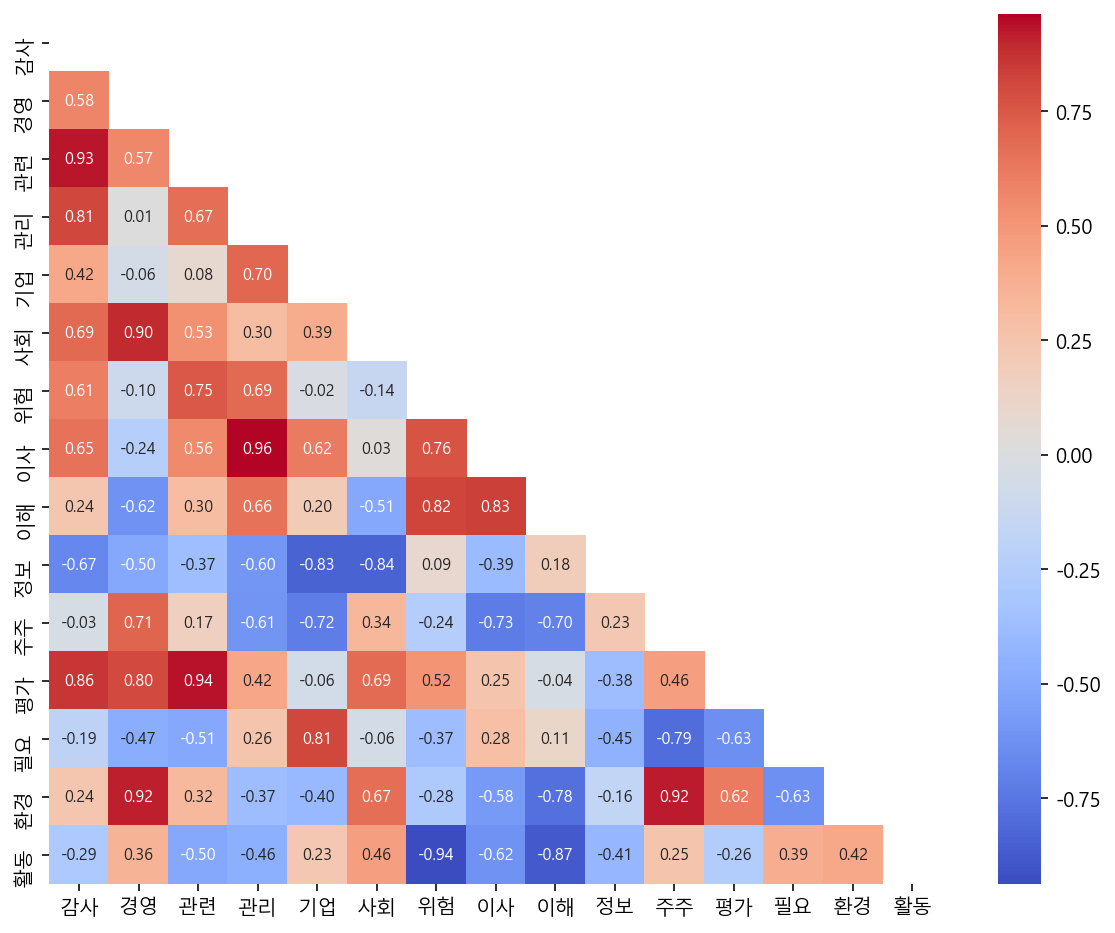

In [56]:
visualize_similarity(word_similarity_matrix, vocab)

In [57]:
from sklearn.manifold import TSNE

def visualize_vectors(vectors, labels):
    tsne = TSNE(n_components=2, n_iter=10000, perplexity=2)
    np.set_printoptions(suppress=True)
    T = tsne.fit_transform(vectors)

    plt.figure(figsize=(10, 6))
    plt.scatter(T[:,0], T[:, 1], c='orange', edgecolors='r')
    for label, x, y in zip(labels, T[:,0], T[:, 1]):
        plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

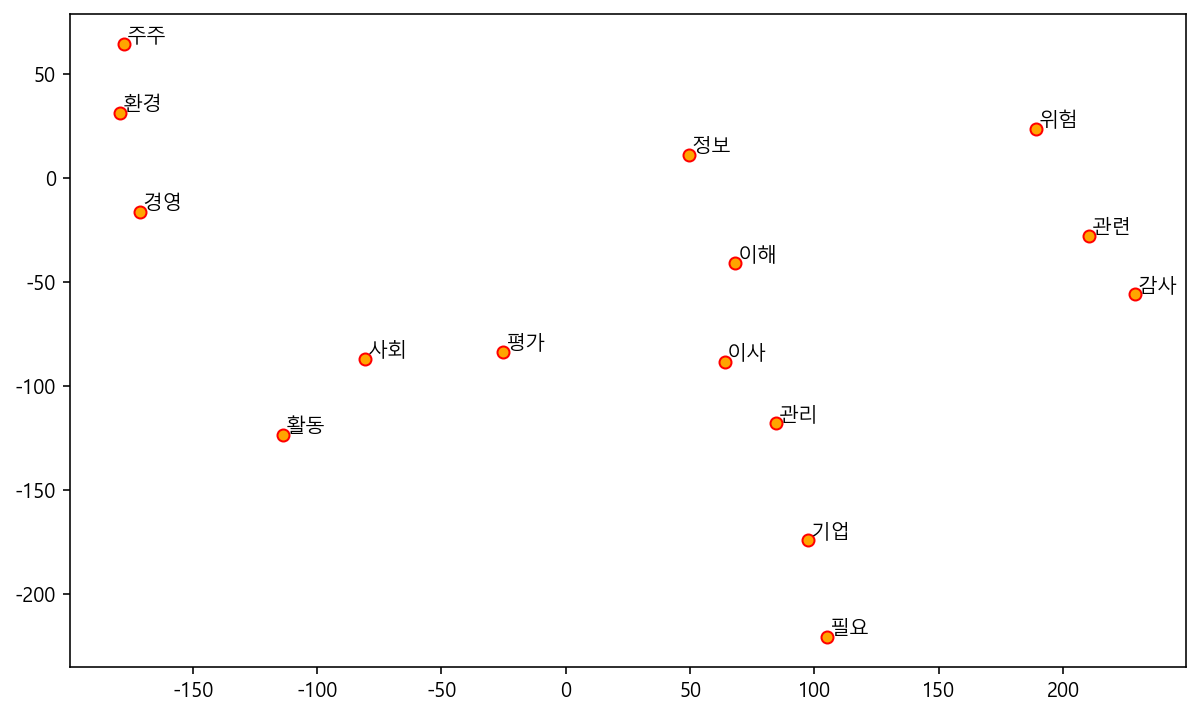

In [58]:
visualize_vectors(word_vectors, vocab)

In [59]:
new_ESG_standard = new_ESG_standard.replace("\n", " ")
test = re.sub("[0-9\•\/\(\)\[\]\{\}\·\'\'\"\"\`\%\㎡\*\━\‘\’\●\★\,]+", " ", new_ESG_standard).replace("\x0c", "")

In [60]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rnru1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [61]:
sent_text = sent_tokenize(test)

In [62]:
normalized_text = []
for string in sent_text:
    tokens = re.sub(r"[^a-z0-9가-힣]+", " ", string.lower())
    normalized_text.append(tokens)

result = [word_tokenize(sentence) for sentence in normalized_text]

In [63]:
print('총 샘플의 개수 : {}'.format(len(result)))

총 샘플의 개수 : 1548


In [64]:
for line in result[:3]:
    print(line)

['cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'contents', 'contents', '환경', '모범규준', '전문', '리더십과', '거버넌스', '위험', '관리', '운영', '및', '성과', '이해관계자', '소통', '부록', '참고문헌', '사회', '모범규준', '전문', '리더십과', '거버넌스', '비재무', '위험', '관리', '운영', '및', '성과', '이해관계자', '소통', '부록', '참고문헌', '지배구조', '모범규준', '전문', '이사회', '리더십', '주주권', '보호', '감사', '주주', '및', '이해관계자와의', '소통', '참고문헌', '환경', '모범규준', '전문', '리더십과', '거버넌스', '위험', '관리', '운영', '및', '성과', '이해관계자', '소통', '부록', '참고문헌', 'korea', 'corporate', 'governance', 'service', '전문', '환경', '모범규준의', '제정', '배경', '기업경영에', '있어', '환경문제가', '기업의', '지속가능한', '발전에', '중요한', '영향을', '미치는', '변수로', '부각됨에', '따라', '국내', '기업도', '환경경영을', '통해', '기업의', '지속가능성과', '수익성을', '동시에', '고려하려는', '세계적', '흐름에', '적극적이고', '능동적으

In [65]:
from gensim.models import Word2Vec
model = Word2Vec(sentences=result, size=100, window=5, min_count=5, workers=4, sg=0)

In [67]:
model_result = model.wv.most_similar("지배구조")
print(model_result)

[('부록', 0.9997047185897827), ('모범규준', 0.9996888041496277), ('사회', 0.9996823072433472), ('기업은', 0.9996626377105713), ('보호', 0.9996490478515625), ('관련', 0.999647855758667), ('www', 0.9996429681777954), ('등을', 0.9996421337127686), ('등의', 0.9996405839920044), ('한다', 0.9996375441551208)]
